In [6]:
import itertools
import os

import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import community as community_louvain


# matplotlib.use('TkAgg')
%matplotlib inline

warnings.simplefilter('ignore')

In [7]:
def readNetGML(path):
    graph = nx.Graph()
    
    with open(path, 'r') as f:
        lines = f.readlines()

    nodes = set()
    edges = set()
    inside_edge_block = False
    source = None
    target = None

    for line in lines:
        if line.strip().startswith("node"):
            inside_edge_block = False
        elif line.strip().startswith("edge"):
            inside_edge_block = True
            source = None
            target = None
        elif inside_edge_block:
            if "source" in line:
                source = int(line.split()[-1])
                nodes.add(source)
            elif "target" in line:
                target = int(line.split()[-1])
                nodes.add(target)
            if source is not None and target is not None:
                if (source, target) not in edges and (target, source) not in edges:
                    edges.add((source, target))

    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    return graph


def chooseMethod(method, graph):
    if method == 'louvain':
        resolution = 1.0
        return community_louvain.best_partition(graph, resolution=resolution)

    elif method == 'girvan_newman':
        comp = nx.algorithms.community.centrality.girvan_newman(graph)
        limited = itertools.takewhile(lambda c: len(c) <= 5, comp)
        return next(limited)

    else:
        raise ValueError("Unknown method")


def modularity(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']

    M = 2 * noEdges
    Q = 0.0

    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if communities[i] == communities[j]:
                Q += (mat[i][j] - degrees[i] * degrees[j] / M)

    return Q * 1 / M


# Densitatea internă a comunităților este definită ca raportul dintre numărul de muchii dintr-o comunitate și numărul maxim posibil de muchii din acea comunitate
def internal_density(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    
    community_nodes = {}
    for node, community in enumerate(communities):
        if community not in community_nodes:
            community_nodes[community] = []
        community_nodes[community].append(node)
    
    total_density = 0
    for nodes in community_nodes.values():
        if len(nodes) > 1:
            subgraph_edges = sum(mat[i][j] for i in nodes for j in nodes if i != j)
            max_edges = len(nodes) * (len(nodes) - 1)
            density = subgraph_edges / max_edges
            total_density += density
            
    average_density = total_density / len(community_nodes)
    return average_density


# Separarea comunităților măsoară raportul dintre numărul de muchii care conectează noduri din comunități diferite și numărul total de muchii din graf
def cut_ratio(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    noEdges = param['noEdges']

    external_edges = 0
    for i in range(noNodes):
        for j in range(noNodes):
            if communities[i] != communities[j] and mat[i][j] > 0:
                external_edges += 1

    cut_ratio_value = external_edges / (2 * noEdges)
    return cut_ratio_value


def plotNetwork(graph):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(graph, pos, node_size=600, cmap='plasma')
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    plt.title("The network graph")
    plt.show()


def plotCommunities(graph, pos, communities):
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(graph, pos, node_size=600, cmap='plasma', node_color=communities)
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    plt.title("Visualising the communities from the network")
    plt.show()


def processNetwork(path):
    graph = readNetGML(path)
    print("The current graph is: ", graph)

    network = {
        'noNodes': graph.number_of_nodes(),
        'noEdges': graph.number_of_edges(),
        'degrees': [d for n, d in graph.degree()],
        'mat': nx.to_numpy_array(graph).tolist()
    }

    pos = nx.spring_layout(graph)
    plotNetwork(graph)

    method = 'louvain'
    # method = 'girvan_newman'

    partition = chooseMethod(method, graph)

    if method == 'louvain':
        communities = [partition[node] for node in graph.nodes()]
    elif method == 'girvan_newman':
        # Map nodes to community indices
        node_list = list(graph.nodes())
        node_index = {node: idx for idx, node in enumerate(node_list)}
        
        communities = [None] * graph.number_of_nodes()
        for community_index, community in enumerate(partition):
            for node in community:
                communities[node_index[node]] = community_index
                
    plotCommunities(graph, pos, communities)

    # Evaluarea utilizând densitatea internă
    print("Internal Density of the community separation: ", internal_density(communities, network))

    # Evaluarea utilizând cut ratio
    print("Cut Ratio of the community separation: ", cut_ratio(communities, network))

    # Evaluarea utilizând modularitatea
    print("Evaluation of the community separation: ", modularity(communities, network))

The current graph is:  Graph with 62 nodes and 159 edges


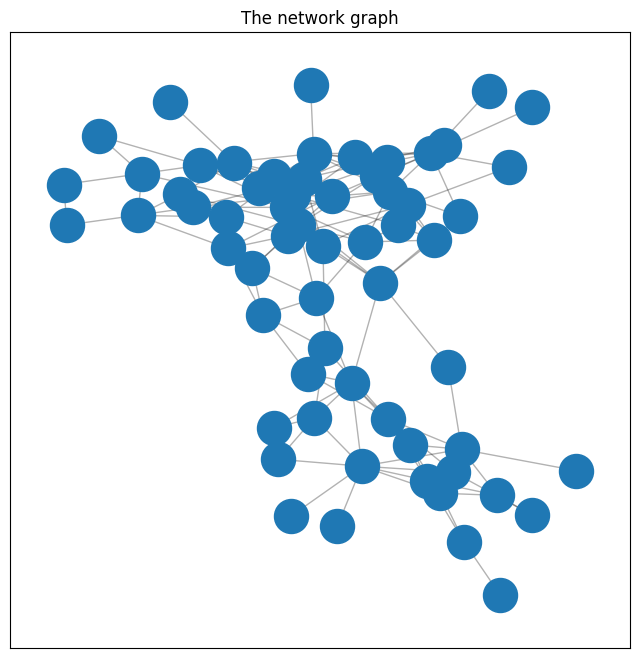

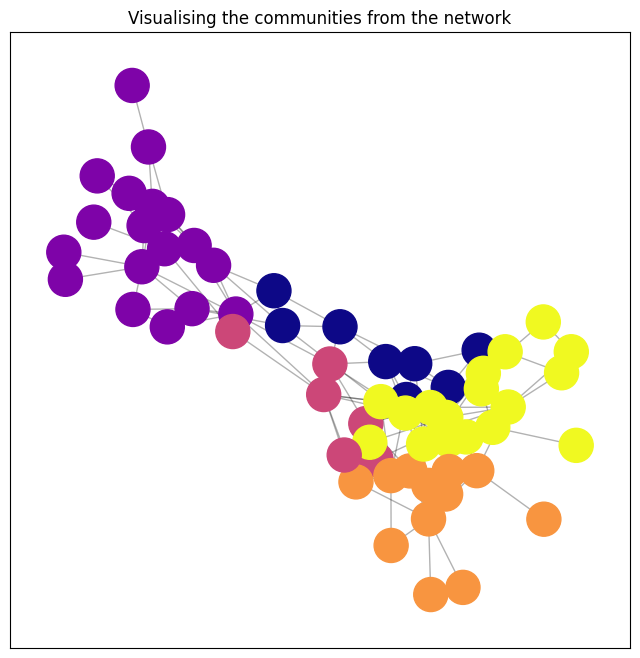

Internal Density of the community separation:  0.34623801035565743
Cut Ratio of the community separation:  0.24528301886792453
Evaluation of the community separation:  0.5188283691309665
The current graph is:  Graph with 115 nodes and 613 edges


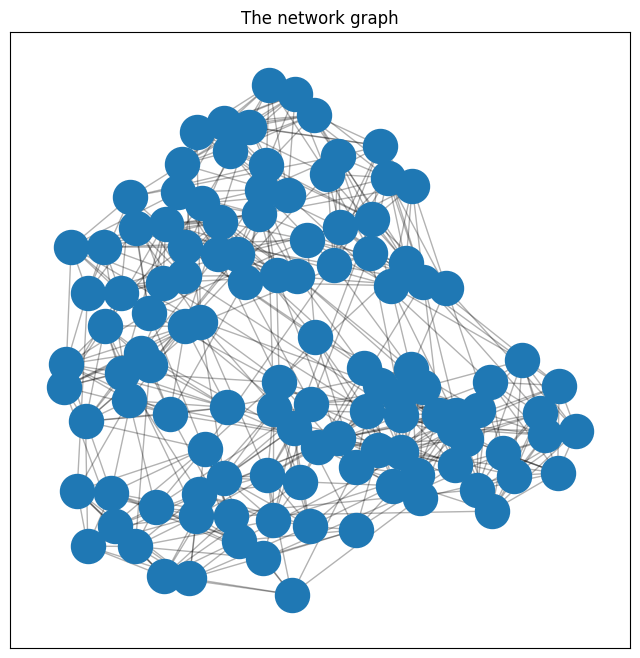

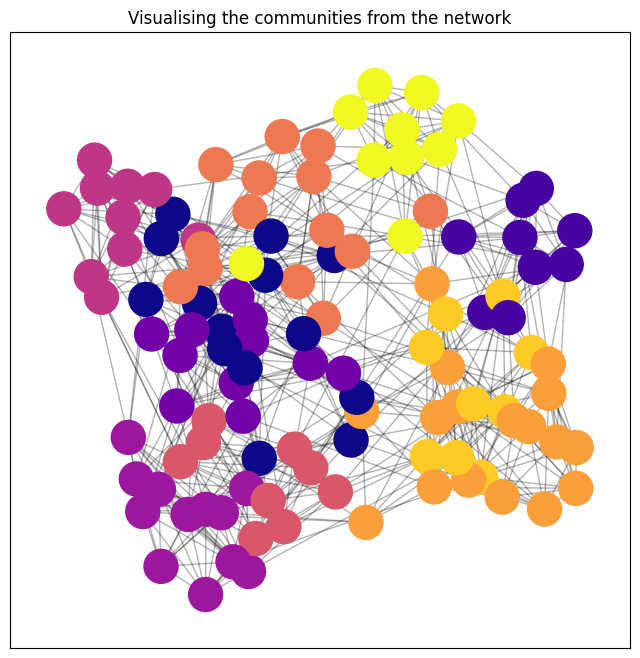

Internal Density of the community separation:  0.7631811978870802
Cut Ratio of the community separation:  0.29200652528548127
Evaluation of the community separation:  0.6043460210927404
The current graph is:  Graph with 34 nodes and 78 edges


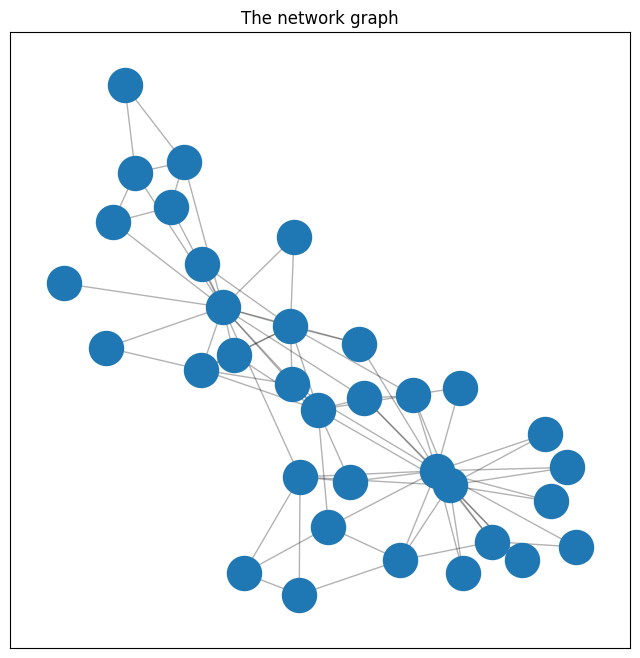

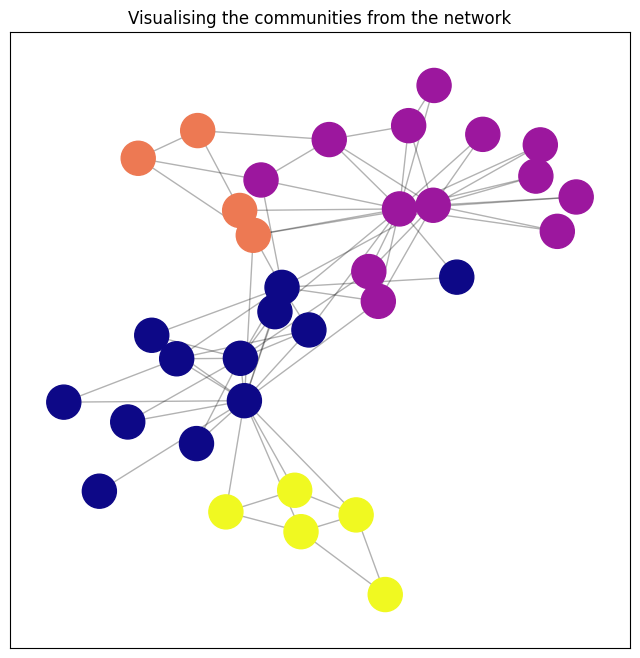

Internal Density of the community separation:  0.48770396270396266
Cut Ratio of the community separation:  0.24358974358974358
Evaluation of the community separation:  0.4155982905982902
The current graph is:  Graph with 105 nodes and 441 edges


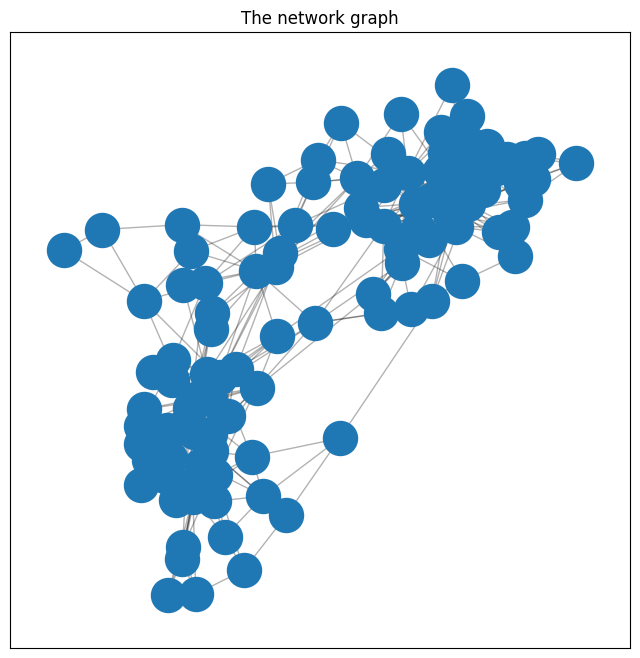

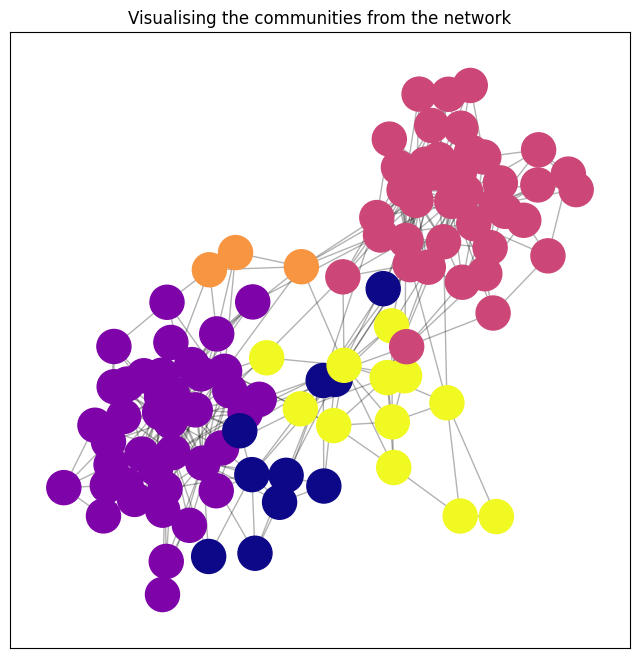

Internal Density of the community separation:  0.44866355866355867
Cut Ratio of the community separation:  0.1111111111111111
Evaluation of the community separation:  0.5272365938060971


In [3]:
def main():
    crtDir = os.getcwd()

    filePaths = [
        os.path.join(crtDir, 'data', 'real-networks', 'dolphins', 'dolphins.gml'),
        os.path.join(crtDir, 'data', 'real-networks', 'football', 'football.gml'),
        os.path.join(crtDir, 'data', 'real-networks', 'karate', 'karate.gml'),
        os.path.join(crtDir, 'data', 'real-networks', 'krebs', 'krebs.gml')
    ]

    for filePath in filePaths:
        processNetwork(filePath)


main()

The current graph is:  Graph with 4941 nodes and 6594 edges


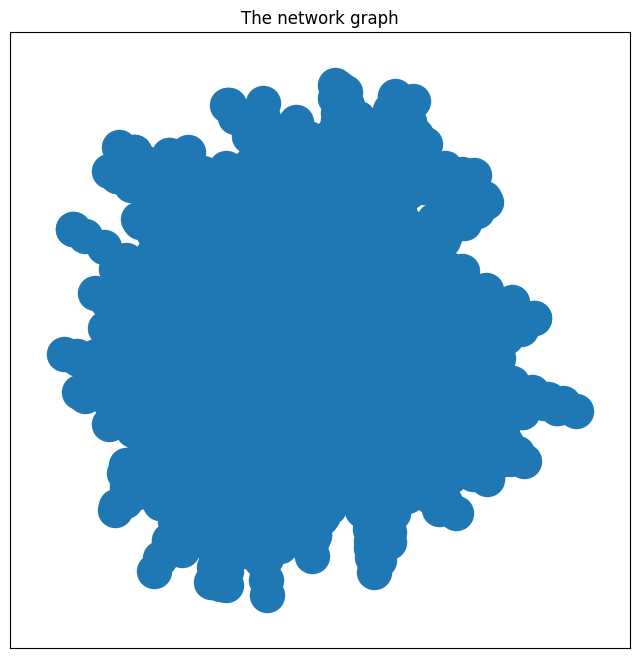

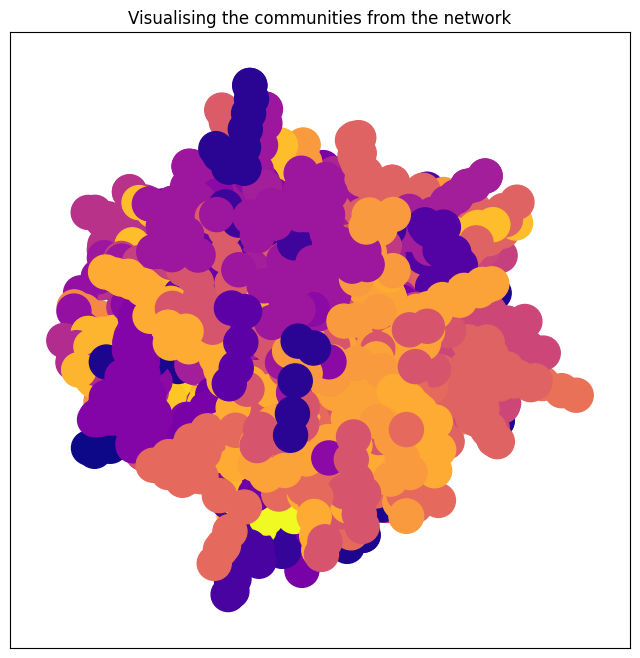

Internal Density of the community separation:  0.031443775943797284
Cut Ratio of the community separation:  0.03381862299059751
Evaluation of the community separation:  0.9367586791560433
The current graph is:  Graph with 297 nodes and 2148 edges


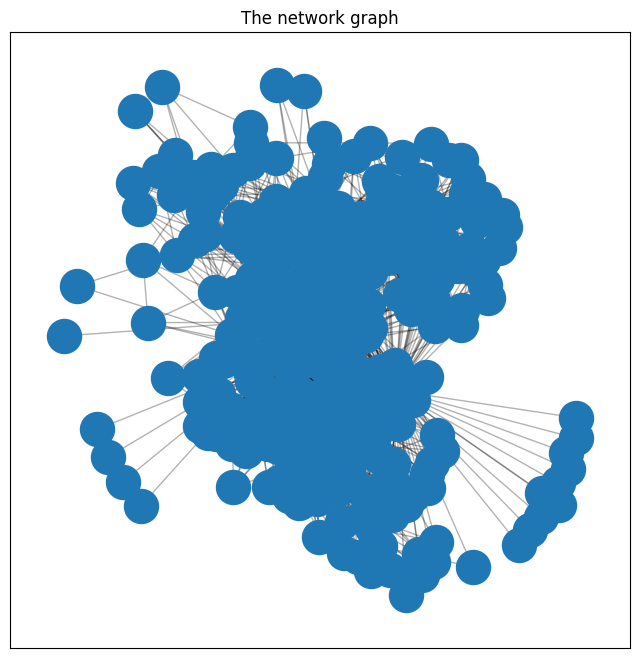

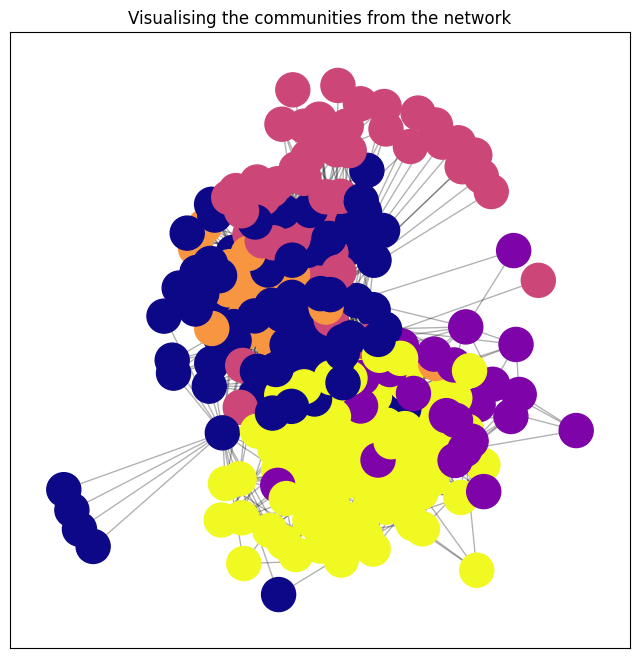

Internal Density of the community separation:  0.19388943523745958
Cut Ratio of the community separation:  0.33891992551210426
Evaluation of the community separation:  0.3857484897821942
The current graph is:  Graph with 115 nodes and 613 edges


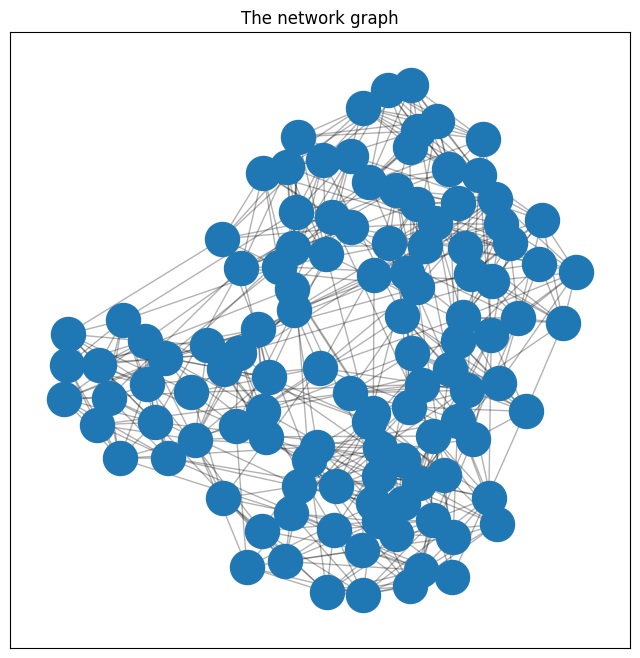

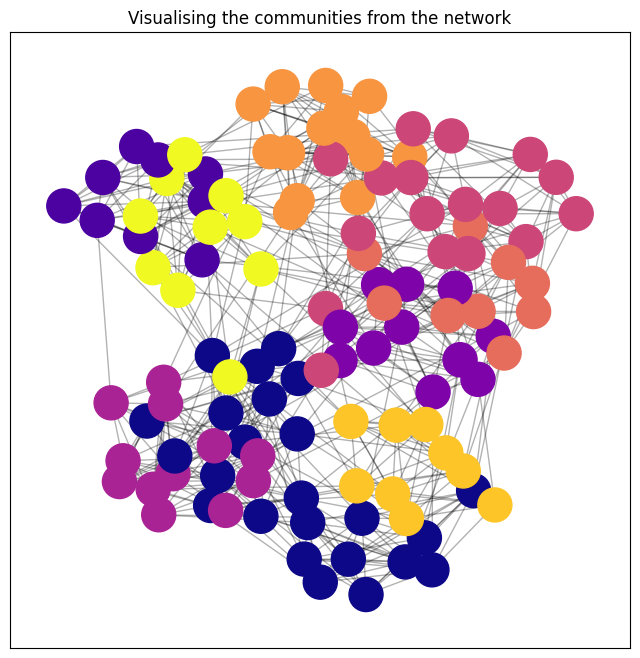

Internal Density of the community separation:  0.7312658434994328
Cut Ratio of the community separation:  0.2707993474714519
Evaluation of the community separation:  0.6041836873185322
The current graph is:  Graph with 77 nodes and 254 edges


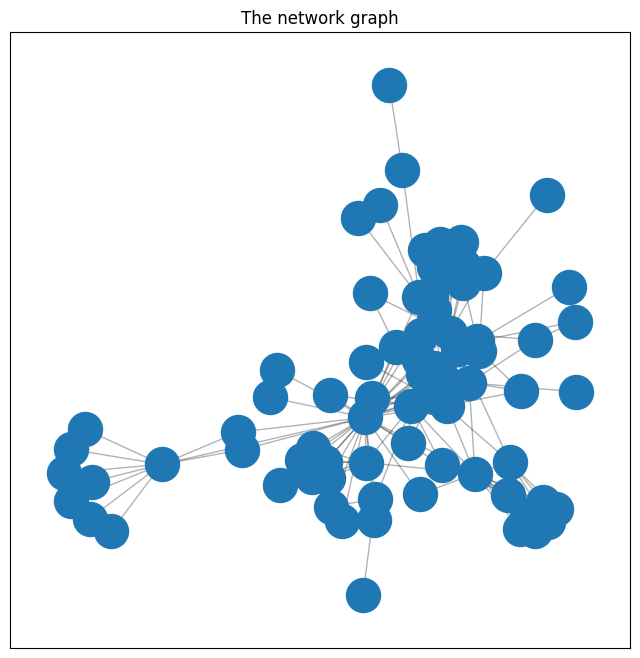

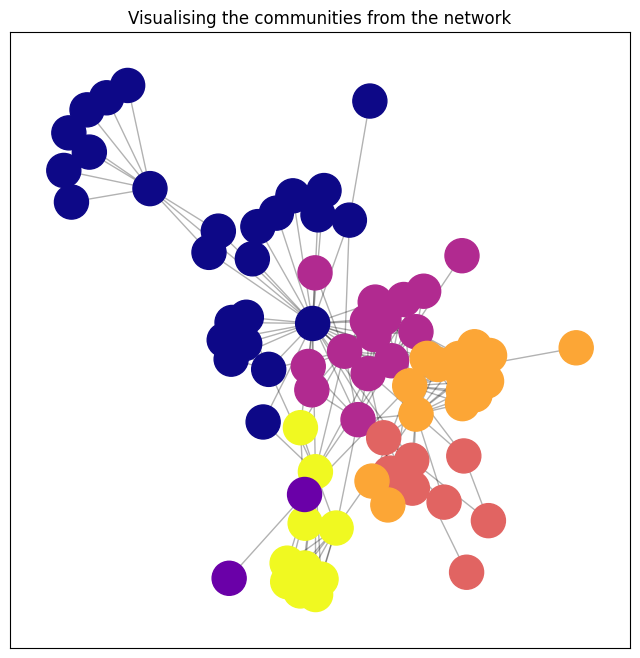

Internal Density of the community separation:  0.5228947903947904
Cut Ratio of the community separation:  0.20866141732283464
Evaluation of the community separation:  0.5488638477276974
The current graph is:  Graph with 1224 nodes and 16718 edges


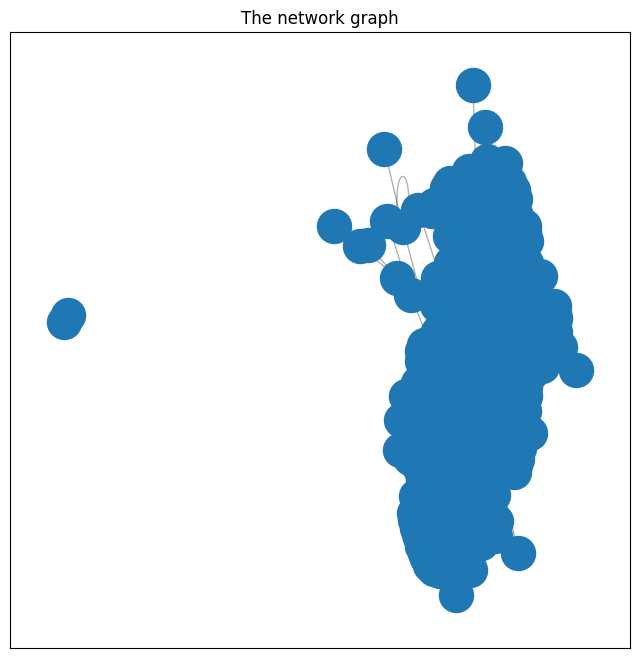

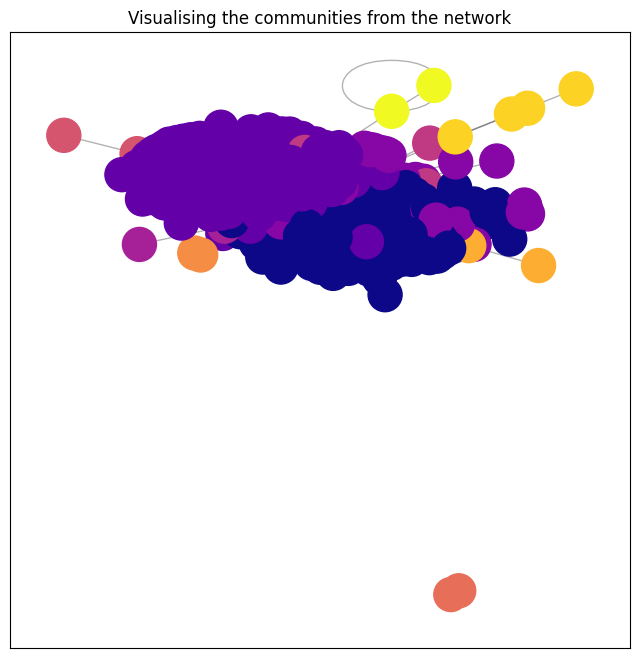

Internal Density of the community separation:  0.6228960019622013
Cut Ratio of the community separation:  0.07991386529489174
Evaluation of the community separation:  0.4270811607865229
The current graph is:  Graph with 105 nodes and 441 edges


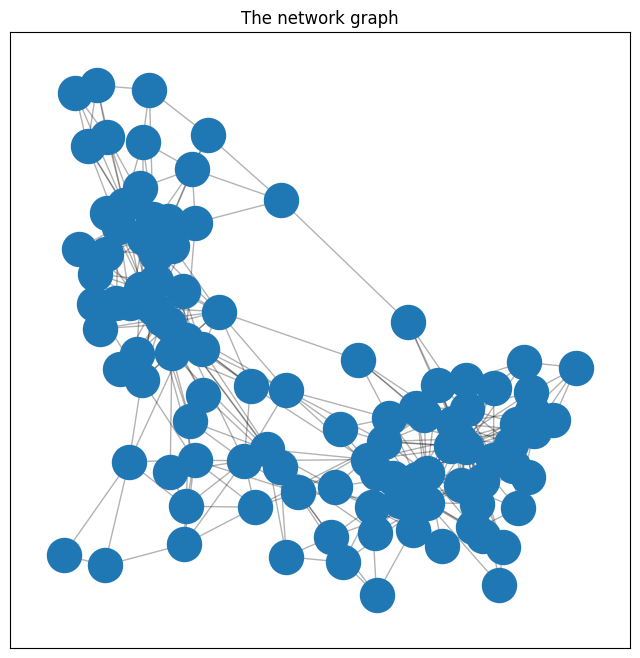

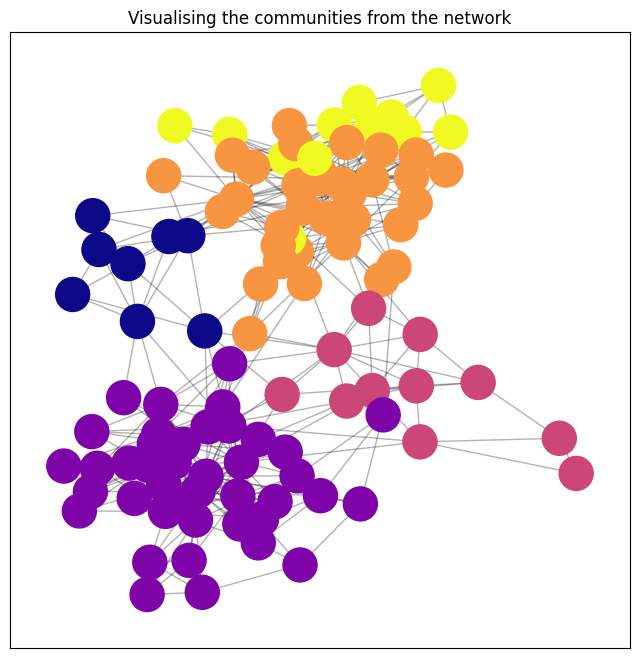

Internal Density of the community separation:  0.3796584309998944
Cut Ratio of the community separation:  0.15419501133786848
Evaluation of the community separation:  0.5266195669500028


In [13]:
def main():
    crtDir = os.getcwd()

    filePaths = [
        os.path.join(crtDir, 'data', 'my-networks', 'power', 'power.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'celegansneural', 'celegansneural.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'football', 'football.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'lesmis', 'lesmis.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'polblogs', 'polblogs.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'polbooks', 'polbooks.gml')
    ]

    for filePath in filePaths:
        processNetwork(filePath)


main()